# (Re)Introduction to Neural Networks
Advanced Machine Learning Lab 1

Hanna Jarlaczyńska

### I. Supervised Learning - Classification

In [1]:
# Install required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:11<00:00, 2229547.53it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200920.71it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1420710.96it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14030069.52it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Define the neural network architecture
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Initialize the model, loss function, and optimizer
model = FashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training the model
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print("Finished training")

In [7]:
# Evaluate the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%")

In [8]:
# Visualizing some test images with their predictions
def visualize_predictions(model, test_loader):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 10))
    for i in range(1, 10):
        ax = fig.add_subplot(3, 3, i)
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap="gray")
        ax.set_title(f"Pred: {predicted[i].item()}, Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()

In [9]:
train(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 0.4853
Epoch [2/5], Loss: 0.3618
Epoch [3/5], Loss: 0.3260
Epoch [4/5], Loss: 0.2996
Epoch [5/5], Loss: 0.2807
Finished training


In [10]:
test(model, test_loader)

Test accuracy of the model on the 10,000 test images: 87.85%


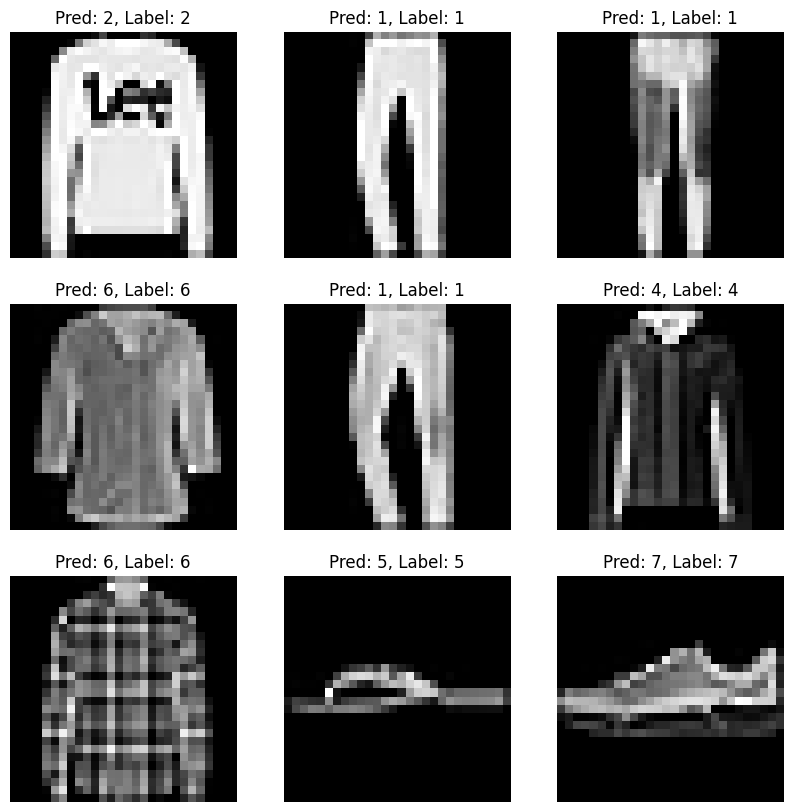

In [11]:
visualize_predictions(model, test_loader)

### II. Unsupervised Learning - Dimensionality reduction

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Load the Fashion MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 32)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),  # output between 0 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        # encoding
        encoded = self.encoder(x)
        # decoding
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

In [16]:
# Initialize
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Training
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # Forward pass
        reconstructed = model(data)
        loss = criterion(reconstructed, data)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0227
Epoch [2/10], Loss: 0.0187
Epoch [3/10], Loss: 0.0152
Epoch [4/10], Loss: 0.0158
Epoch [5/10], Loss: 0.0140
Epoch [6/10], Loss: 0.0135
Epoch [7/10], Loss: 0.0117
Epoch [8/10], Loss: 0.0122
Epoch [9/10], Loss: 0.0120
Epoch [10/10], Loss: 0.0128


In [18]:
# Test the autoencoder
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        break

In [19]:
def imshow(img, title):
    img = img.cpu().numpy()
    plt.imshow(img[0], cmap="gray")
    plt.title(title)
    plt.show()

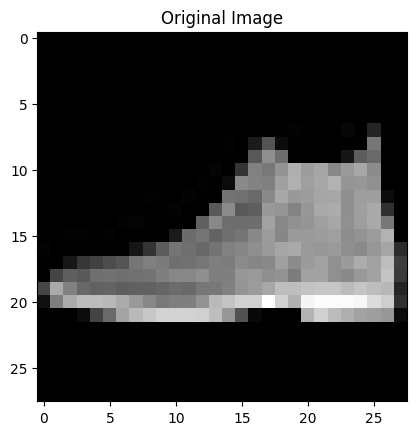

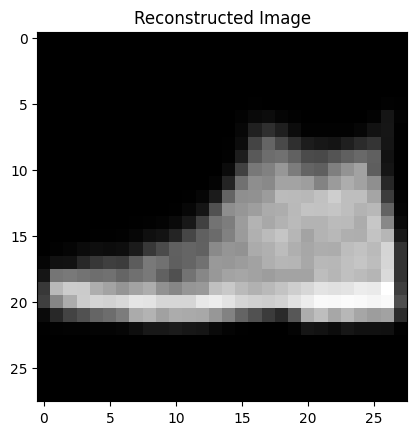

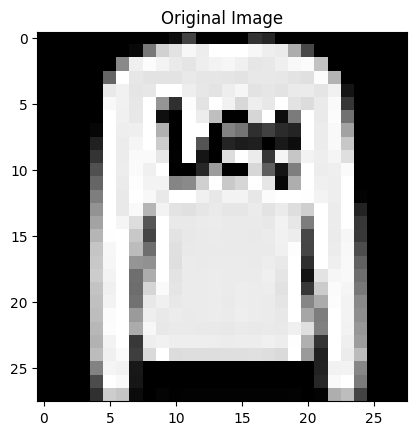

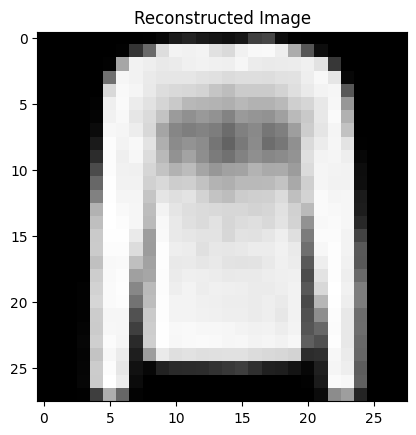

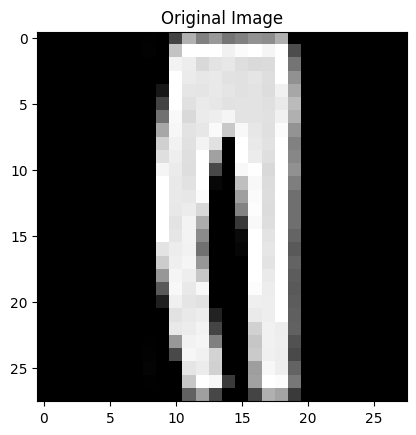

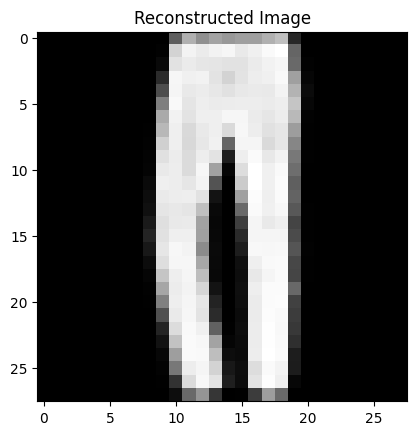

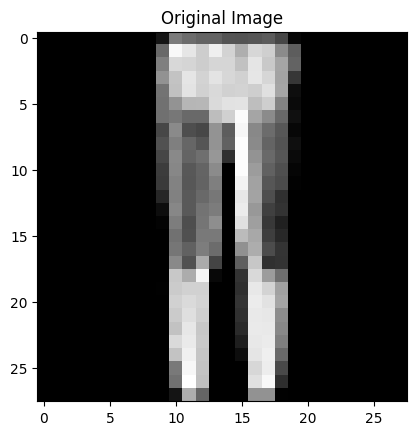

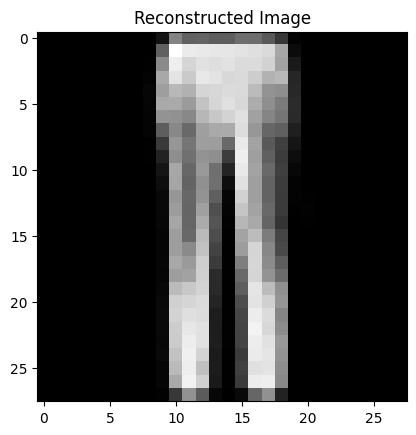

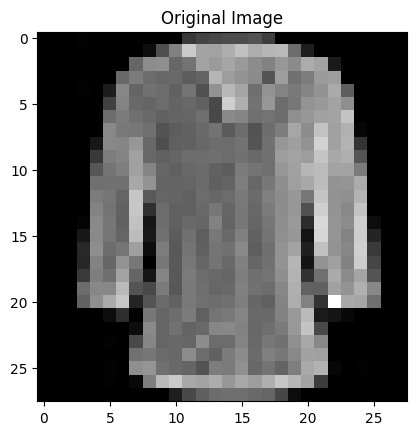

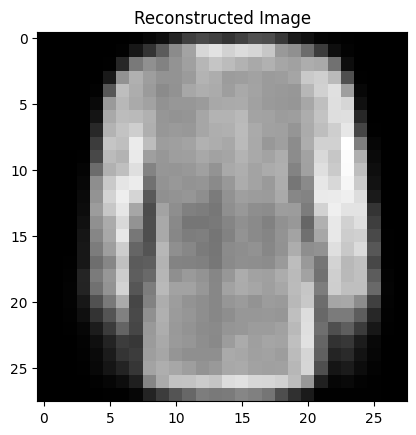

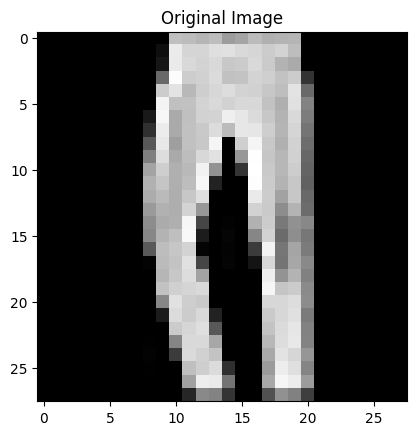

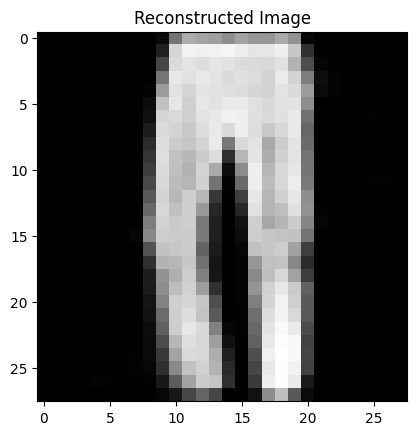

In [20]:
for i in range(6):
    imshow(data[i], "Original Image")
    imshow(output[i], "Reconstructed Image")

### III. Usage of pre-trained models - Speech Recognition

In [28]:
!pip install pytube

In [37]:
import torch
import torchaudio
import moviepy.editor as mp
import IPython
import matplotlib.pyplot as plt

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Import clip from The Big Short (downloaded before)
clip = mp.VideoFileClip("video.mp4")
audio_path = "audio.wav"
clip.audio.write_audiofile(audio_path)

MoviePy - Writing audio in audio.wav


MoviePy - Done.


In [36]:
# Load the pretrained Wav2Vec2 model
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

model = bundle.get_model().to(device)
print(model.__class__)

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [38]:
# Check audio file
IPython.display.Audio("audio.wav")

Output hidden; open in https://colab.research.google.com to view.

In [39]:
# Load data
waveform, sample_rate = torchaudio.load("audio.wav")
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [40]:
# Extract acoustic features
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


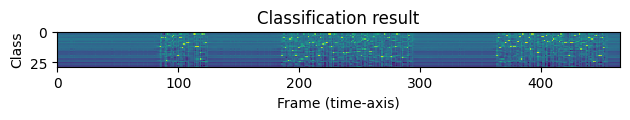

In [42]:
# Feature classification
with torch.inference_mode():
    emission, _ = model(waveform)

plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [43]:
# Define greedy decoding algorithm
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [44]:
# Decode transcript
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [45]:
# Check results
print(transcript)
IPython.display.Audio("audio.wav")

Output hidden; open in https://colab.research.google.com to view.

### IV. DIY Implementation - Artificial Neuron Model

In separate notebook